<img src = "bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Short Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting $parcelvalue$, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and $transactiondate$ is the date when the property was effectively sold. Properties are defined by $lotid$, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

+ Using this data build a predictive model for $parcelvalue$ 
+ Try a first quick implementation, then try to optimize hyperparameters
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

Please use *Mean Absolute Error* to report accuracy.
$$MAE ={\frac {\sum _{i=1}^{n}\left|\hat{y_{i}}-y_{i}\right|}{n}}$$

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Removing features that have more than 40% of missing data
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Predict $parcelvalue$ on a new input file (*Regression_Supervised_Test_1.csv*) and report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.

### Hints
Here we give some hints by simplicity of solution.
#### Simple solution
+ Load training data.
+ Get rid of missing data by dropping columns with missing data. Use *dropna* function of pandas.
+ Convert some categorical features to numerical using pandas *get_dummies* function.
+ Scale your input features using *sklearn.preprocessing.StandardScaler*
+ Log transform *parcelvalue*.
+ Fit a linear regression model with some regularization using *Lasso* function of *sklearn.linear*
+ Apply same pre-processing pipeline to test data
+ Predict test *parcelvalue* using the linear model fitted to training data.
+ Report accuracy on test data

#### Intermediate solution
+ Use GridSearchCV to find out best *alpha* parameter.
+ Explore which variables are more relevant to predict *parcelvalue*.
+ Assess expected accuracy with Cross Validation (use high number of folds).
+ Show the Lasso path to check how less relevant features are shrunk to zero.
+ Report accuracy on test set.

#### Advanced solution
+ Use extra approaches to manage missing data. Hint: explore $SingleImputer$ or $IterativeImputer$.
+ Properly encode every categorical variable. Hint: explore *category_encoders* library.
+ Compare with a non-linear model (e.g. decision trees model).



## Exploration

Here we provide some code to load relevant packages, load data and do a preliminar preprocessing.

In [1]:
## Your code here (click on the window and type 'b' if you want to split in more than one code window)
# Set seed for reproducibility
my_seed=3462
import random 
random.seed(my_seed)

import numpy as np
np.random.seed(my_seed)

from re import sub
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import re
from sklearn.linear_model import lars_path, lasso_path 

# Optional
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import xgboost as xgb

# Plot libraries
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns #optional
import plotly.express as px # optional



**Step 1**: Read data and report missing data

In [2]:
# Read data
dat = pd.read_csv('./Data/Regression_Supervised_Train.csv', sep=',', header=0)
dat_test = pd.read_csv('./Data/Regression_Supervised_Test_1.csv', sep=',', header=0)

dat['ID']=range(dat.shape[0])
dat_test['ID']=range(dat_test.shape[0])

# Make a copy of data for later use
dat_original=dat.copy()
dat_t_original=dat_test.copy()

print(dat.head())

      lotid transactiondate  aircond  style  basement  numbath  numbedroom  \
0  17056626      2016-09-30      NaN    NaN       NaN      1.5         2.0   
1  11077562      2017-04-03      1.0    NaN       NaN      3.0         4.0   
2  12849228      2017-01-06      1.0    NaN       NaN      4.0         4.0   
3  14389898      2016-08-26     13.0    NaN       NaN      3.0         4.0   
4  12357460      2016-06-01      NaN    NaN       NaN      1.0         2.0   

   classbuild  qualitybuild  decktype  ...  material  unitnum    year  \
0         NaN           NaN       NaN  ...       NaN      NaN  1956.0   
1         NaN           7.0       NaN  ...       NaN      1.0  1979.0   
2         NaN           7.0       NaN  ...       NaN      1.0  1995.0   
3         NaN           NaN       NaN  ...       NaN      NaN  1983.0   
4         NaN           7.0       NaN  ...       NaN      1.0  1947.0   

   numstories  fireplace  parcelvalue  taxyear  taxdelinquencyflag  \
0         1.0        N

<BarContainer object of 44 artists>

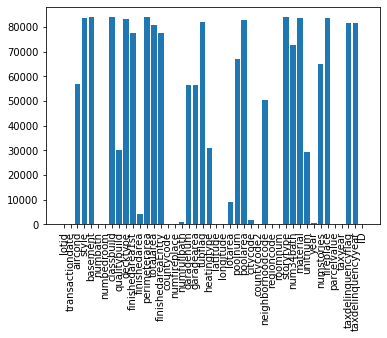

In [3]:
# Compute nulls per feature
Nulls= dat.isnull().sum()
plt.xticks(rotation='vertical')
plt.bar(Nulls.index, Nulls.values)

We can drop those columns that have one unique value, or that have close pairwise correlation with another one.

In [4]:
dat.nunique()

lotid                 83253
transactiondate         598
aircond                   6
style                     6
basement                 38
numbath                  21
numbedroom               17
classbuild                1
qualitybuild             12
decktype                  1
finishedarea1st        1831
finishedarea           4923
perimeterarea            12
totalarea              1826
finishedareaEntry      1851
countycode                3
numfireplace              6
numfullbath              12
garagenum                14
garagearea              862
tubflag                   1
heatingtype              11
latitude              68384
longitude             66729
lotarea               19495
poolnum                   1
poolarea                279
citycode                177
countycode2               3
neighborhoodcode        490
regioncode              389
roomnum                  16
storytype                 1
num34bath                 5
material                  4
unitnum             

Before that, we will fill empty values by a FALSE for those binary variables that have only a unique value (TRUE): *fireplace*, *poolnum* and *tubflag*. Here we assume that people only report e.g. poolnum whenever they have a pool.

In [5]:
dat['tubflag'] = pd.to_numeric(dat['tubflag'])
dat['fireplace'] = pd.to_numeric(dat['fireplace'])

In [6]:
dat[['fireplace','tubflag','poolnum']]=dat[['fireplace','tubflag','poolnum']].fillna(0)

Now we remove remaining features with only one unique value.

In [7]:
dat.columns[dat.nunique()==1]

Index(['classbuild', 'decktype', 'storytype', 'taxdelinquencyflag'], dtype='object')

In [8]:
dat.drop(dat.columns[dat.nunique()==1].values, axis=1, inplace=True)
dat.nunique()

lotid                 83253
transactiondate         598
aircond                   6
style                     6
basement                 38
numbath                  21
numbedroom               17
qualitybuild             12
finishedarea1st        1831
finishedarea           4923
perimeterarea            12
totalarea              1826
finishedareaEntry      1851
countycode                3
numfireplace              6
numfullbath              12
garagenum                14
garagearea              862
tubflag                   2
heatingtype              11
latitude              68384
longitude             66729
lotarea               19495
poolnum                   2
poolarea                279
citycode                177
countycode2               3
neighborhoodcode        490
regioncode              389
roomnum                  16
num34bath                 5
material                  4
unitnum                   9
year                    134
numstories                4
fireplace           

Here we explore the correlation between features.

In [9]:
dat = dat.reindex(sorted(dat.columns), axis=1)
corr = dat.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\joan.verdu\.conda\envs\r-tutorial\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning:

invalid value encountered in less



Remove *numfullbath* because it's highly correlated to *numbath*

In [10]:
corr['numbath'][corr['numbath']>=0.95]

numbath        1.000000
numfullbath    0.984258
Name: numbath, dtype: float64

In [11]:
dat.drop('numfullbath', axis=1,inplace=True)

Then we remove *countycode2* because has basically same information as *countycode*.

In [12]:
dat.countycode.head(10)

0    6111.0
1    6037.0
2    6037.0
3    6059.0
4    6037.0
5    6037.0
6    6059.0
7    6037.0
8    6037.0
9    6037.0
Name: countycode, dtype: float64

In [13]:
dat.countycode2.head(10)

0    2061.0
1    3101.0
2    3101.0
3    1286.0
4    3101.0
5    3101.0
6    1286.0
7    3101.0
8    3101.0
9    3101.0
Name: countycode2, dtype: float64

In [14]:
print(dat.countycode.nunique())
print(dat.countycode2.nunique())
aux=dat[['countycode','countycode2']].dropna()
aux=aux.countycode+aux.countycode2
print(len(set(aux)))

3
3
3


In [15]:
dat.drop(['countycode2'],inplace=True, axis=1)

Drop observations with no *parcelvalue* and let's check the distribution of our target variable.

In [16]:
dat.dropna(subset = ['parcelvalue'],inplace=True)

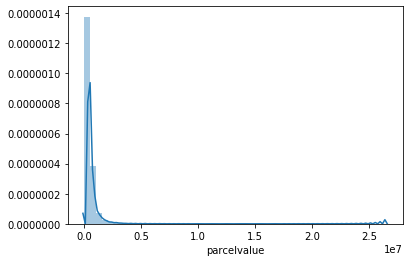

In [17]:
#histogram
sns.distplot(pd.Series(dat['parcelvalue']))

It's quite skewed, we might want to do a transform before fitting the model.

Finally, do same transformations on test data.

In [18]:
# Do same transformations to test data
dat_test2=dat_test.copy()
dat_test2[['fireplace','tubflag','poolnum']]=dat_test2[['fireplace','tubflag','poolnum']].fillna(0)
dat_test2=dat_test2.fillna(method='ffill')# Adding this one for simplicity, to be able to predict all observations instead of dropping some
dat_test2.isnull().sum(axis = 0)

dat_test2=dat_test2.filter(items=dat.columns)

In [19]:
dat_or=dat.copy()
dat_test_or=dat_test2.copy()



## Your solution 

In [20]:
# Step 2: Remove features with missing data, and then observations with missing data


In [21]:
# Step 3: Create dummies for relevant features (we keep regioncode as it is, too many unique values, we will check later)


In [22]:
# Step 4: Build your model and get predictions from train data



In [23]:
# Step 5 (optional): Assess expected accuracy using cross-validation
# Step 6 (optional): Report which variable impacts more on results 

In [24]:
# Step 7: Run and report with new file

